# Moving average convergence/divergence (MAC) and Williams %R (WR) strategy creation
In this notebook we are going to create a strategy that uses [MACD](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Williams%R)](https://en.wikipedia.org/wiki/Relative_strength_index). 

Williams %R is a momentum indicator that is the inverse of the Fast Stochastic Oscillator. Where values between 0 to -20 are considered overbought and -80 to -100 are considered oversold. Williams %R reflects the level of the close relative to the highest high for the look-back period. This is a bound oscillator and oscillates from 0 to -100

Entry signal
Bullish Crossover
Description: Occurs when the MACD line crosses above the Signal line.
Implication: Indicates a potential upward trend and is often considered a buy signal.
Example: If the MACD line (blue) crosses above the Signal line (orange), it suggests increasing positive momentum.

Exit signal
Bearish Crossover
Description: Occurs when the MACD line crosses below the Signal line.
Implication: Indicates a potential downward trend and is often considered a sell signal.
Example: If the MACD line (blue) crosses below the Signal line (orange), it suggests increasing negative momentum.

This notebook will walk you through the following processes:

* Download all market data
* Determine up and down trends in the market data and convert them to Backtest dateranges
* Visualize all market data
* Create RSI and ADX metric calculation functions
* Visualize all market data and metrics
* Create a strategy based on the metrics with the investing algorithm framework
* Backtest the strategy with different configurations.
* Evaluate the backtest reports to determine the best configuration

## Install requirements

In [ ]:
try:
    import investing_algorithm_framework  
    print(f"investing_algorithm_framork is already installed.")
except ImportError:
    print("investing_algorithm_framork is not installed. Installing...")
    import sys
    !{sys.executable} -m pip install investing_algorithm_framework

try:
    import ipywidgets
    print(f"ipywidgets is already installed.")
except ImportError:
    print("ipywidgets is not installed. Installing...")
    import sys
    !{sys.executable} -m pip install ipywidgets

investing_algorithm_framork indicators plugin is not installed. Installing...
zsh:1: no matches found: investing_algorithm_framework[indicators]
ipywidgets is already installed.


## Define data sources
We will use the `ccxt` library to download the data and provide our strategy with the necessary data when backtesting and live trading. We will 
use OHLCV (Open, High, Low, Close and Volume) data from the Bitvavo exchange for the BTC/EUR trading pair.

In [ ]:
import os
from investing_algorithm_framework import CCXTOHLCVMarketDataSource

# Define data storage path. The data provider will write all its downloaded data to this directory. 
# If at this location all files already exist it will just read from the files instead of downloading everything.
storage_path = os.path.join(os.getcwd(), "data")
two_hour_btc_eur_data_source = CCXTOHLCVMarketDataSource(
    identifier="BTC/EUR_OHLCV",
    symbol="BTC/EUR",
    market="BITVAVO",
    time_frame="2h",
    storage_path=storage_path
)

one_day_btc_eur_data_source = CCXTOHLCVMarketDataSource(
    identifier="BTC/EUR_OHLCV",
    symbol="BTC/EUR",
    market="BITVAVO",
    time_frame="1d",
    storage_path=storage_path    
)

## Download and analyse data

In this section we are going to download all required data, deteremine up and down trend, define the backtest date ranges, and visualize the data with our strategy indicators.

We want to indentify up and down trends in the data for optimization of our strategy later during backtesting. For example, if the strategy performs well in up trends but poorly in down trends, we can optimize the strategy to perform better in down trends by changing the strategy configuration. The goal here is to create date ranges for up and down trends so we can evaluate the strategy performance in different market conditions.

In [ ]:
from datetime import datetime, timedelta
from investing_algorithm_framework import DateRange

total_date_range = DateRange(
    start_date=datetime(year=2021, month=1, day=1), 
    end_date=datetime(year=2024, month=6, day=1), 
    name="Total date range"
)

# Our start date for our data is different then our start_date for our backtest range. This is because we will be using indicators such as the 200 sma, 
# which need to have atleast 200 data points before the start date of our backtest range. If we don't do this,
# we can't calculate indicators such as the 200 sma for our strategy.
start_date_data = total_date_range.start_date - timedelta(days=200)

### Download all data for the total date range

In [ ]:
total_data_polars_df = one_day_btc_eur_data_source.get_data(
    start_date=total_date_range[0], end_date=total_date_range[1],
)

### Define all backtest date ranges and indentify up and down trends. 

We are going to define all the backtesting date ranges that we are going to use to backtest our strategy. The total date range we are going to test is the period of 2021-12-21 - 2024-06-01. For strategy optimization purposes, we are going to determine then up and down trends of this date range and add these to our backtest date ranges. This will result in a date range list that consists of total period (2021-12-21 - 2024-06-01) and the individual up and down trends in this period.


In [ ]:
from investing_algorithm_framework import BacktestDateRange, convert_polars_to_pandas
from investing_algorithm_framework.indicators import detect_up_and_downtrends

backtest_date_ranges = [BacktestDateRange(name="total_date_range", start_date=total_date_range[0], end_date=total_date_range[1])]

# Detect up and down trends 
total_data_pandas_df = convert_polars_to_pandas(total_data_polars_df)
trends = detect_up_and_downtrends(total_data_pandas_df)

for tred_indicator in trends:
    backtest_date_ranges.append(
        BacktestDateRange(name=tred_indicator, start_date=trends[tred_indicator][0], end_date=trends[tred_indicator][1])
    )

### Visualize all the data with strategy indicators

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from investing_algorithm_framework.indicators import get_sma

# Add sma 50 and sma 200
total_data_pandas_df = get_sma(total_data_pandas_df, period=50, source_column_name="Close", result_column_name="SMA_50")
total_data_pandas_df = get_sma(total_data_pandas_df, period=200, source_column_name="Close", result_column_name="SMA_200")

# Create tabbed results
tab_contents = []
tab_titles = []

for i, date_range in enumerate(backtest_date_ranges):

    if date_range.up_trend is None and date_range.down_trend is None:
        title = f"All Data"
    else:
        if date_range.up_trend:
            title = f"Up Trend ({date_range.start_date.date()} to {date_range.end_date.date()})"
        else:
            title = f"Down Trend ({date_range.start_date.date()} to {date_range.end_date.date()})"

    tab_titles.append(title)
    
    # Slice DataFrame for the date range
    df_slice = total_data_pandas_df.loc[date_range.start_date:date_range.end_date]    

    # Add price graph
    graph = go.Scatter(
        x=df_slice.index,
        y=df_slice["Close"],
        mode='lines',
        line=dict(color="blue", width=2),
        name="Close Price"
    )

    # Add 50-day moving average graph
    graph_sma_50 = go.Scatter(
        x=df_slice.index,
        y=df_slice[f"SMA_50"],
        mode='lines',
        line=dict(color="red", width=2),
        name="50-day SMA"
    )

    # Add 200-day moving average graph
    graph_sma_200 = go.Scatter(
        x=df_slice.index,
        y=df_slice[f"SMA_200"],
        mode='lines',
        line=dict(color="green", width=2),
        name="200-day SMA"
    )

    # Create a Plotly figure for the DataFrame slice
    fig = go.FigureWidget()
    fig.add_trace(graph)
    fig.add_trace(graph_sma_50)
    fig.add_trace(graph_sma_200)
    fig.update_layout(
        title=f"Close Prices from {date_range.start_date.date()} to {date_range.end_date.date()} ({date_range.name})",
        xaxis_title='Date',
        yaxis_title='Close Price'
    )
    
    # Create a widget for the Plotly figure
    tab_contents.append(widgets.Output())
    
    with tab_contents[-1]:
        display(fig)

# Create and display tabs
tabs = widgets.Tab()
tabs.children = tab_contents

for i, title in enumerate(tab_titles):
    tabs.set_title(i, title)

display(tabs)

/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/examples/example_strategies/macd_wr/data
/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/examples/example_strategies/macd_wr/data


TypeError: create_storage_file_path() got an unexpected keyword argument 'time_frame'

## Add strategy indicators and visualize the data

We will add the RSI and ADX indicators to the data so we can visualize the data and determine how the strategy performs in different market conditions. We will use the `ta` library to calculate the RSI and ADX indicators.

In [14]:
from plotly import graph_objects as go
from investing_algorithm_framework.indicators import get_peaks
import pandas as pd

def create_macd_chart(data: pd.DataFrame):

    # Check if the index is of type datetime
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The index of the data should be of type datetime")

    # Check if the data has the required columns
    if 'MACD' not in data.columns:
        raise ValueError("The data should have a 'MACD' column")
    if 'MACD_SIGNAL' not in data.columns:
        raise ValueError("The data should have a 'MACD_SIGNAL' column")
    
    # Create crossover signals
    bearish_crossover_index = data[(data['MACD'] < data['MACD_SIGNAL']) & (data['MACD'].shift(1) > data['MACD_SIGNAL'].shift(1))].index
    bearish_crossover_values = data.loc[bearish_crossover_index, 'MACD']
    bullish_crossunder_index = data[(data['MACD'] > data['MACD_SIGNAL']) & (data['MACD'].shift(1) < data['MACD_SIGNAL'].shift(1))].index
    bullish_crossunder_values = data.loc[bullish_crossunder_index, 'MACD']

    bearish_crossover_graph = go.Scatter(
        x=bearish_crossover_index,
        y=bearish_crossover_values,
        mode='markers',
        marker=dict(symbol='circle', size=10, color='red'),
        name='MACD bearish Crossover'
    )

    bullish_crossunder_graph = go.Scatter(
        x=bullish_crossunder_index,
        y=bullish_crossunder_values,
        mode='markers',
        marker=dict(symbol='circle', size=10, color='green'),
        name='MACD bullish Crossover'
    )

    # Add MACD line
    macd_graph = go.Scatter(
        x=data.index,
        y=data['MACD'],
        mode='lines',
        name='MACD'
    )

    # Add MACD Signal line
    macd_signal_graph = go.Scatter(
        x=data.index,
        y=data['MACD_SIGNAL'],
        mode='lines',
        name='MACD Signal'
    )

    # Add MACD Histogram
    macd_histogram_graph = go.Bar(
        x=data.index,
        y=data['MACD_HISTOGRAM'],
        name='MACD Histogram'
    )

    return macd_graph, macd_signal_graph, macd_histogram_graph, bearish_crossover_graph, bullish_crossunder_graph


def create_peaks_chart(data: pd.DataFrame, key):

    # Check if the index is of type datetime
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The index of the data should be of type datetime")

    keys = [f'{key}_highs', f'{key}_lows']

    for key_column in keys:
        if key_column not in data.columns:
            raise ValueError(f"The data should have a '{key_column}' column")

    # Get all peak indexes
    hh_close_index = data[data[f'{key}_highs'] == 1].index
    lh_close_index = data[data[f'{key}_highs'] == -1].index
    ll_close_index = data[data[f'{key}_lows'] == 1].index
    hl_close_index = data[data[f'{key}_lows'] == -1].index

    # Subtract for each index 10 hours
    hh_close_index = hh_close_index - pd.Timedelta(hours=2 * 3)
    lh_close_index = lh_close_index - pd.Timedelta(hours=2 * 3)
    ll_close_index = ll_close_index - pd.Timedelta(hours=2 * 3)
    hl_close_index = hl_close_index - pd.Timedelta(hours=2 * 3)

    # Function to find nearest values
    def get_nearest_values(indexes, data, key):
        values = []
        for idx in indexes:
            if idx in data.index:
                values.append(data.loc[idx, key])
            else:
                nearest_idx = data.index.get_indexer([idx], method='nearest')
                if nearest_idx[0] != -1:
                    values.append(data.iloc[nearest_idx[0]][key])
        return values

    # Use the function to get the corresponding 'Close' values
    hh_close_values = get_nearest_values(hh_close_index, data, key)
    lh_close_values = get_nearest_values(lh_close_index, data, key)
    ll_close_values = get_nearest_values(ll_close_index, data, key)
    hl_close_values = get_nearest_values(hl_close_index, data, key)

    # Add higher highs
    higher_high_graph = go.Scatter(
        x=hh_close_index,
        # x=dates[hh_close_index - order].values,
        y=hh_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=5, color='blue'),
        name='Higher High Confirmation'
    )

    # Add lower highs
    lower_high_graph = go.Scatter(
        x=lh_close_index,
        y=lh_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=5, color='red'),
        name='Lower High Confirmation'
    )

    # Add lower lows
    lower_lows_graph = go.Scatter(
        x=ll_close_index,
        y=ll_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=5, color='green'),
        name='Lower Lows Confirmation'
    )

    # Add higher lows
    higher_lows = go.Scatter(
        x=hl_close_index,
        y=hl_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=5, color='purple'),
        name='Higher Lows Confirmation'
    )

    return higher_high_graph, lower_high_graph, lower_lows_graph, higher_lows

def create_entry_graph(data: pd.DataFrame):
    """
    Create an entry graph indicating bullish crossover signals.
    """
    entry_indexes = []

    for idx, row in enumerate(data.itertuples(index=True), start=1):
        selected_rows = data.iloc[:idx]

        # Check if there is a bullish crossover between MACD and MACD Signal line
        if Strategy.is_crossover(selected_rows, "MACD", "MACD_SIGNAL"):
            # Get the last higher high or lower high index
            # Select the rows where WILLR_highs is either -1 or 1
            peaks = selected_rows[(data['WILLR_highs'] == -1) | (selected_rows['WILLR_highs'] == 1)]

            if len(peaks) == 0 or row.WILLR > -20 or row.MACD == 0:
                continue
            
            # Select the last row from the filtered data
            last_row = peaks.iloc[-1]
            
            # Check if the peak was within the last 12 rows
            if last_row.name in data.index[max(0, idx-24):idx]:
                entry_indexes.append(row.Index)  # Append the actual index value

    entry_close_values = data.loc[entry_indexes, 'Close']

    return go.Scatter(
        x=entry_indexes,
        y=entry_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=10, color='green'),
        name='Entry Signal'
    )

def create_entry_graph_v2(data: pd.DataFrame):
    """
    Create an entry graph indicating bullish crossover signals.
    """
    entry_indexes = []

    for idx, row in enumerate(data.itertuples(index=True), start=1):
        selected_rows = data.iloc[:idx]

        # Check if there is a bullish crossover between MACD and MACD Signal line
        if Strategy.is_crossover(selected_rows, "MACD", "MACD_SIGNAL") and row.WILLR < -30:

            if row.WILLR > -20 or row.MACD == 0:
                continue
        
            entry_indexes.append(row.Index)  # Append the actual index value

    entry_close_values = data.loc[entry_indexes, 'Close']

    return go.Scatter(
        x=entry_indexes,
        y=entry_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=10, color='green'),
        name='Entry Signal'
    )

def create_entry_graph_v3(data: pd.DataFrame):
    """
    Create an entry graph indicating bullish crossover signals.
    """
    entry_indexes = []

    for idx, row in enumerate(data.itertuples(index=True), start=1):
        selected_rows = data.iloc[:idx]

        # Check if there is a bullish crossover between MACD and MACD Signal line
        if Strategy.is_crossover(selected_rows, "MACD", "MACD_SIGNAL") and row.WILLR < -30:

            if row.WILLR > -20 or row.MACD == 0:
                continue

            # Select the rows where WILLR_highs is either -1 or 1
            peaks = selected_rows[(data['WILLR_highs'] == -1) | (selected_rows['WILLR_highs'] == 1)]
            
            # Select the last higher high or lower high index
            if len(peaks) == 0:
                continue

            # Select the last row from the filtered data
            last_peak_row = peaks.iloc[-1]

            # Caclulate the slope between the current row WILLR and the last peak WILLR
            # 2 hours
            delta = (row.Index - last_peak_row.name).total_seconds() / 7200

            if delta == 0:
                continue
            
            slope = Strategy.calculate_slope(((row.WILLR, delta), (last_peak_row.WILLR, 0)))

            if slope < -0.5:
            # Slope should be smaller then negative 0.5, meaning a large decrease in the WILLR value
                entry_indexes.append(row.Index)  # Append the actual index value

    entry_close_values = data.loc[entry_indexes, 'Close']

    return go.Scatter(
        x=entry_indexes,
        y=entry_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=10, color='green'),
        name='Entry Signal'
    )


def create_exit_graph(data: pd.DataFrame):
    """
    """
    exit_indexes = []

    for idx, row in enumerate(data.itertuples(index=True), start=1):
        selected_rows = data.iloc[:idx]

        # Check if there is a bearish crossover between MACD and MACD Signal line
        if Strategy.is_crossunder(selected_rows, "MACD", "MACD_SIGNAL") or row.WILLR > -20:
        
            # # Check if in the past 12 rows (24 hours) there was a crossover above the -50 range of the Williams %R
            # selection = data.iloc[max(0, idx-12):idx]

            # if Strategy.has_crossed_upward(selection, "WILLR", -50):
            exit_indexes.append(row.Index)
        
    exit_close_values = data.loc[exit_indexes, 'Close']
    return go.Scatter(
        x=exit_indexes,
        y=exit_close_values,
        mode='markers',
        marker=dict(symbol='circle', size=10, color='red'),
        name='Entry Signal'
    )

In [ ]:
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from investing_algorithm_framework.indicators import get_peaks
from strategy import Strategy

df = Strategy.add_macd(df)
df = Strategy.add_willr(df)
df = get_peaks(df, key="WILLR", order=3, k=2)

# Create tabbed results
tab_contents = []
tab_titles = []

for i, date_range in enumerate(trend_data_ranges):
    title = f"Range ({date_range.name} {date_range.start_date.date()} to {date_range.end_date.date()})"
    tab_titles.append(title)
    
    # Slice DataFrame for the date range
    df_slice = df.loc[date_range.start_date:date_range.end_date]    

    # Add price graph
    close_price = go.Scatter(
        x=df_slice.index,
        y=df_slice["Close"],
        mode='lines',
        line=dict(color="blue", width=2),
        name="Close Price"
    )

    # Add Williams%R graph
    willr_graph = go.Scatter(
        x=df_slice.index,
        y=df_slice["WILLR"],
        mode='lines',
        line=dict(color="orange", width=2),
        name="Williams%R"
    )

    willr_higher_high_graph, willr_lower_high_graph, willr_lower_lows_graph, willr_higher_lows = create_peaks_chart(df_slice, key="WILLR")
    macd_graph, macd_signal_graph, macd_histogram_graph, bearish_crossover_graph, bullish_crossover_graph = create_macd_chart(df_slice)

    # Create a Plotly figure for the DataFrame slice
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.2)
    fig.add_trace(close_price, row=1, col=1)
    fig.add_trace(willr_graph, row=2, col=1)
    fig.add_trace(macd_graph, row=3, col=1)
    fig.add_trace(macd_signal_graph, row=3, col=1)
    # fig.add_trace(macd_histogram_graph, row=3, col=1)
    fig.add_trace(bearish_crossover_graph, row=3, col=1)
    fig.add_trace(bullish_crossover_graph, row=3, col=1)
    fig.add_trace(willr_higher_high_graph, row=4, col=1)
    fig.add_trace(willr_lower_high_graph, row=4, col=1)
    fig.add_trace(willr_lower_lows_graph, row=4, col=1)
    fig.add_trace(willr_higher_lows, row=4, col=1)
    fig.add_trace(willr_graph, row=4, col=1)
    # fig.add_trace(create_entry_graph(data=df_slice), row=1, col=1)
    # fig.add_trace(create_entry_graph_v2(data=df_slice), row=5, col=1)
    fig.update_layout(
        title=f"Close Prices from {date_range.start_date.date()} to {date_range.end_date.date()} ({date_range.name})",
        xaxis_title='Date',
        yaxis_title='Close Price'
    )
    
    widget = go.FigureWidget(fig)
    # Create a widget for the Plotly figure
    tab_contents.append(widgets.Output())
    
    with tab_contents[-1]:
        display(widget)

# Create and display tabs
tabs = widgets.Tab()
tabs.children = tab_contents

for i, title in enumerate(tab_titles):
    tabs.set_title(i, title)

display(tabs)
# for i, date_range in enumerate(date_ranges):
#     start_date = date_range.start_date
#     end_date = date_range.end_date
#     df = data_source.get_data(start_date=start_date, window_size=200)
#     df = convert_polars_to_pandas(df)
    # df = Strategy.add_macd(df)
    # df = Strategy.add_willr(df)
    # df = get_peaks(df, key="WILLR", order=3, k=2)
#     widget = go.FigureWidget()
#     fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.02)
#     fig.add_trace(create_prices_graph(df), row=1, col=1)
#     fig.add_trace(create_prices_graph(df), row=2, col=1)
#     fig.add_trace(create_prices_graph(df), row=3, col=1)
#     willr_higher_high_graph, willr_lower_high_graph, willr_lower_lows_graph, willr_higher_lows = \
#         create_peaks_chart(df, key="WILLR")
#     macd_graph, macd_signal_graph, macd_histogram_graph, bearish_crossover_graph, bullish_crossover_graph = create_macd_chart(df)
#     fig.add_trace(macd_graph, row=4, col=1)
#     fig.add_trace(macd_signal_graph, row=4, col=1)
#     fig.add_trace(macd_histogram_graph, row=4, col=1)
#     fig.add_trace(bearish_crossover_graph, row=4, col=1)
#     fig.add_trace(bullish_crossover_graph, row=4, col=1)
#     fig.add_trace(willr_higher_high_graph, row=5, col=1)
#     fig.add_trace(willr_lower_high_graph, row=5, col=1)
#     fig.add_trace(willr_lower_lows_graph, row=5, col=1)
#     fig.add_trace(willr_higher_lows, row=5, col=1)
#     fig.add_trace(create_line_graph(data=df, data_key="WILLR", color="red", graph_name="Williams%R"), row=5, col=1)
#     fig.add_trace(create_entry_graph_v2(data=df), row=2, col=1)
#     fig.add_trace(create_entry_graph_v3(data=df), row=3, col=1)

#     # fig.add_trace(create_exit_graph(data=df), row=1, col=1)
#     # fig.add_trace(create_exit_graph(data=df), row=2, col=1)
#     fig.update_layout(
#         title={'text': f'Date range: "{date_range.name}" Metrics and entry points', 'x':0.5},
#         autosize=True,
#         height=1000
#     )
#     fig.show()

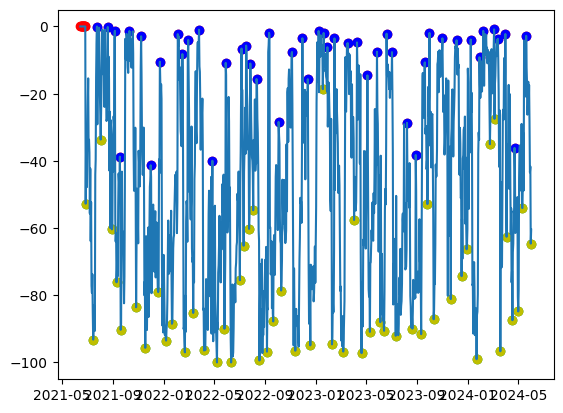

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import argrelextrema


n = 8 # number of points to be checked before and after

# Find local peaks
df["hh"] =  df.iloc[argrelextrema(df["WILLR"].values, np.greater_equal, order=n)[0]]['WILLR']
df["ll"] =  df.iloc[argrelextrema(df["WILLR"].values, np.less, order=n)[0]]['WILLR']
df["lh"] = df.iloc[argrelextrema(df["WILLR"].values, np.greater, order=n)[0]]['WILLR']
df["hl"] = df.iloc[argrelextrema(df["WILLR"].values, np.less, order=n)[0]]['WILLR']

# df['min'] = df.iloc[argrelextrema(df["WILLR"].values, np.less_equal, order=n)[0]]['WILLR']
# df['max'] = df.iloc[argrelextrema(df["WILLR"].values, np.greater_equal,
#                     order=n)[0]]['WILLR']

# Plot results
plt.scatter(df.index, df['hh'], c='r')
plt.scatter(df.index, df['ll'], c='g')
plt.scatter(df.index, df['lh'], c='b')
plt.scatter(df.index, df['hl'], c='y')
plt.plot(df.index, df['WILLR'])
plt.show()